# Physical Modeling
References:
- https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis
- https://ccrma.stanford.edu/~jos/pasp/Karplus_Strong_Algorithm.html
- https://www.youtube.com/watch?v=Li6OEMCtQ9k


In [22]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from IPython.display import Audio

## The Karplus Strong Algorithm
Made in the late 1960s, maybe the mother of digitally implemented physical modeling. Simulates a string with frequency dependent damping. 
![karplus](img/karplus.png)

This basically 'solves' the 1D Wave equation:

$c\frac{\delta^2 f}{\delta x^2} = \frac{\delta^2f}{\delta t^2}$

Where: 
- $c$ is the speed of sound in the medium (string)
- $f$ is the string position (in $y$ if you will)
- $x$ is just the spacial variable along the string
- $t$ is time in seconds


In [2]:
class KarplusStrong():
    def __init__(self, delayLength):
        self.delayLength = delayLength
        self.buffer = np.zeros(self.delayLength)
        self.z1 = 0
        self.writePosition = 0
        self.readPosition = (self.writePosition-1)%self.delayLength 
    def step(self,x,a):
        yDel = self.buffer[self.readPosition]
        ySum = yDel*0.5+self.z1*0.5
        self.z1 = yDel
        y = ySum
        self.buffer[self.writePosition] = y*a+x
        self.incrementPositions()
        return y
    def incrementPositions(self):
        self.writePosition = (self.writePosition+1)%self.delayLength
        self.readPosition = (self.writePosition+self.delayLength)%(self.delayLength)
        

In [3]:
karpl = KarplusStrong(500)

In [4]:
a = 0.99
N= 300000
inputSig = sig.unit_impulse(N, idx=20)
outPutSig = np.zeros_like(inputSig)
for n in range(N):
    outPutSig[n] = karpl.step(inputSig[n],a)
    

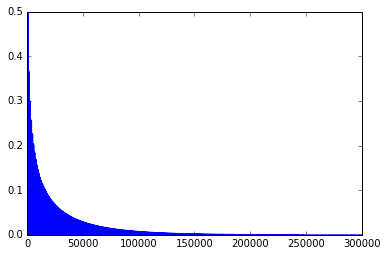

In [5]:
plt.plot(outPutSig)
plt.show()

In [6]:
Audio(data=outPutSig, rate=44100)

/root/miniconda2/envs/findRefrain3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7017: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


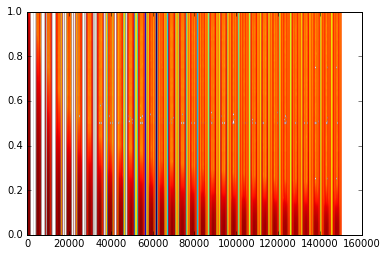

In [7]:
plt.specgram(outPutSig)
plt.show()

## More interesting Exciter
Using a short burst of noise, brings in variation. Filtering this noise can simulate softer excitation of the String.

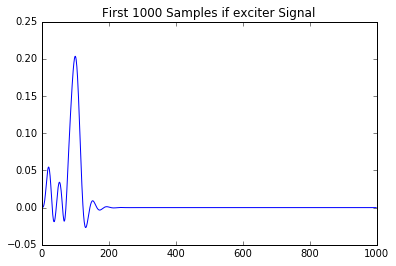

In [8]:
inputSig = (np.random.random(100)-0.5)*2 
inputSig = np.append(inputSig, np.zeros(150000))
lopBa = sig.butter(5,0.05)
inputSig = sig.lfilter(lopBa[0],lopBa[1],inputSig)

plt.plot(inputSig[0:1000])
plt.title("First 1000 Samples if exciter Signal")
plt.show()

In [9]:
a = 0.9
N= len(inputSig)
outPutSig = np.zeros_like(inputSig)
for n in range(N):
    outPutSig[n] = karpl.step(inputSig[n],a)
    

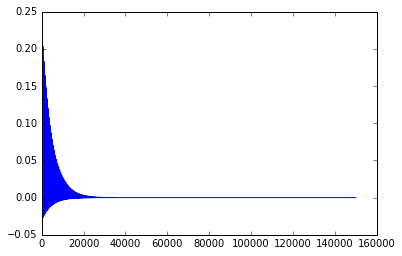

In [10]:
plt.plot(outPutSig)
plt.show()

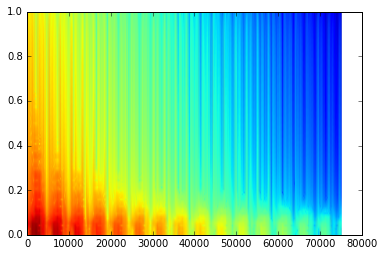

In [11]:
plt.specgram(outPutSig)
plt.show()

In [12]:
Audio(data=outPutSig, rate=44100)

# This has some problems. There should be a Non-Linear allpass, not just the non-linearity.
## Adding a Non-Linearity


This non-linearity can be used to simulate a ratteling string, so a string hitting objects. Basically we introduce something like tis in the feedback path:

$    y(n) = \left\{\begin{array}{lr}
        x(n)\cdot a_1, & \text{for } x(n)\leq a_3\\
        x(n)\cdot a_2, & \text{for } x(n)\gt a_3
        \end{array}\right\}$

So in case the input is greater than some value $a_3$ it is multiplied by $a_2$ otherwise mutlitplied by some value $a_1$. So we have 3 Values to play around with. Typically $a_3$ is close to 0 to intrduce a lot of non-linearity (assuming a DC signal). A DC blocker assures the incoming value is DC so let's define one.

### DC-Blocker

$y(n)= x(n)-x(n-1)+y(n-1)\cdot R$

Where R is a coefficient we can tweak. $R=0.995$ is recommended for $f_s=44100$

https://www.dsprelated.com/freebooks/filters/DC_Blocker.html


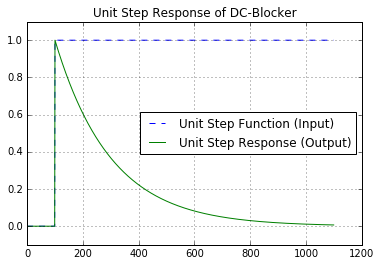

In [13]:
class DCblocker():
    """
    https://www.dsprelated.com/freebooks/filters/DC_Blocker.html
    """
    def __init__(self):
        self.R = 0.995
        self.xn1 = 0
        self.yn1 = 0
        
    def step(self,x):
        y = x - self.xn1 +self.R*self.yn1
        self.xn1= x
        self.yn1 = y
        return y

x = np.append(np.zeros(100),np.ones(1000))
bl = DCblocker()
N = len(x)
Y = np.zeros_like(x)
for n in range(N):
    Y[n] = bl.step(x[n])

plt.plot(x, '--', label='Unit Step Function (Input)')
plt.plot(Y, label='Unit Step Response (Output)')
plt.title('Unit Step Response of DC-Blocker')
plt.legend(loc='best')
plt.ylim([-0.1,1.1])
plt.grid()
plt.show()

So, since the DC blocker is ready, here is the Karplus Strong Algorithm + dcBlocker and non-linearity:

In [14]:
class KarplusStrongNonLin():
    def __init__(self, delayLength):
        self.dcb = DCblocker()
        self.delayLength = delayLength
        self.buffer = np.zeros(self.delayLength)
        self.z1 = 0
        self.z2 = 0
        
        self.writePosition = 0
        self.readPosition = (self.writePosition-1)%self.delayLength 

    def step(self,x,a,a1,a2):
        yDel = self.buffer[self.readPosition]
        
        #DC-Blocking
        ySum = self.dcb.step(yDel)

        #non-linearity
        yDel = self.nonLinearity(ySum,a1,a2)
        
        #simple lowpass
        ySum = yDel*0.5+self.z1*0.5
        self.z1 = yDel
        
        y = ySum
        
        self.buffer[self.writePosition] = np.clip(y*a+x, -0.999, 0.9999)
        
        self.incrementPositions()
        return y

    def incrementPositions(self):
        self.writePosition = (self.writePosition+1)%self.delayLength
        self.readPosition = (self.writePosition+self.delayLength)%(self.delayLength)

    def nonLinearity(self,x,a1,a2):
        if x >=0.1:
            y = x*a1
        else:
            y = x*a2
        
        return y

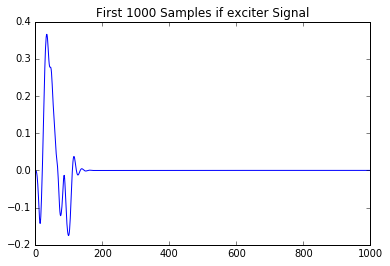

In [15]:
inputSig = (np.random.random(100)-0.5)*2 
inputSig = np.append(inputSig, np.zeros(150000))
lopBa = sig.butter(5,0.09)
inputSig = sig.lfilter(lopBa[0],lopBa[1],inputSig)

plt.plot(inputSig[0:1000])
plt.title("First 1000 Samples if exciter Signal")
plt.show()

In [16]:
karplNl = KarplusStrongNonLin(900)
a = 1.01
a1 = -0.099999
a2= 0.99
N= len(inputSig)

outPutSig = np.zeros_like(inputSig)
for n in range(N):
    outPutSig[n] = karplNl.step(inputSig[n],a,a1,a2)

/root/miniconda2/envs/findRefrain3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7017: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


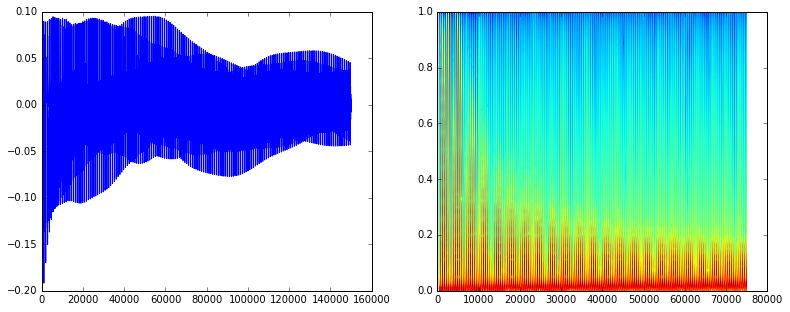

In [17]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(outPutSig)
plt.subplot(122)
plt.specgram(outPutSig)
plt.show()

In [18]:
Audio(data=outPutSig,rate=44100)

### Simple Karplus in Faust
```
import("stdfaust.lib");

imp = 1<:_,_':-;
delTime = hslider("delTime", 1000,1,44100,1);

fbDel = ((_*0.99:lop),_*0.5:+:de.sdelay(44100,1000,delTime))~_;
lop = _:fi.lowpass(3,2000):_;
process = imp:fbDel;

```

# Modal Modeling

In [23]:
x,sr = librosa.load('/root/Desktop/test_mono.wav',sr=None)

In [19]:
import scipy.signal as sig
import numpy as np

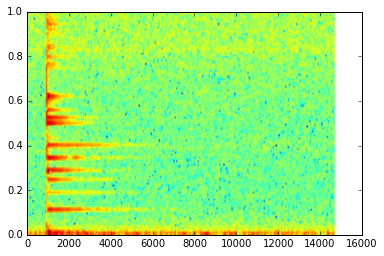

In [24]:
plt.specgram(x)
plt.show()

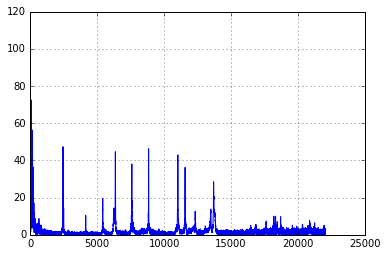

In [215]:
s = np.fft.fft(x)
N = len(s)
halfSpec = s[:int(N/2)]
freqAxis = np.linspace(0,sr/2,len(halfSpec))
plt.plot(freqAxis,abs(halfSpec))
plt.grid()
plt.show()

In [26]:
import peakdetect

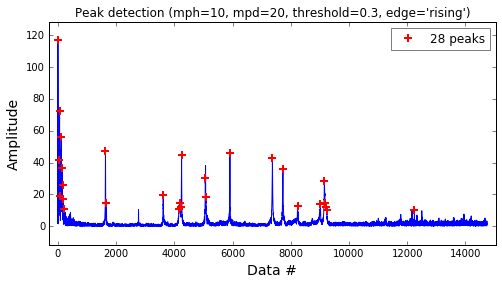

In [216]:
peakIndizes = peakdetect.detect_peaks(abs(halfSpec),mph=10,mpd=20,threshold=.3,show=True)

In [50]:
peakFreqs = (sr/2)*peakIndizes/int(N/2)

In [53]:
np.set_printoptions(suppress=True)

In [54]:
print(peakFreqs)

[     8.14056034     50.47147412     99.31483617    135.13330168
    187.23288786    224.67946544    263.75415508    299.57262058
    341.90353436   2666.84756801   2718.9471542    5895.39379961
   6921.10440269   8282.20609185   9623.7704362   11981.27671121
  14679.05840852  14905.36598603  14963.97802049  19941.11661353]


In [20]:
# def tf2s(b2,b1,b0,a1,a0,w1):
#     _ : resonbp(fc,Q,gain) : _

## Faust Reson BP
```

tf2(b0,b1,b2,a1,a2) = iir((b0,b1,b2),(a1,a2));

tf2s(b2,b1,b0,a1,a0,w1) = tf2(b0d,b1d,b2d,a1d,a2d)
with {
  c   = 1/tan(w1*0.5/ma.SR); // bilinear-transform scale-factor
  csq = c*c;
  d   = a0 + a1 * c + csq;
  b0d = (b0 + b1 * c + b2 * csq)/d;
  b1d = 2 * (b0 - b2 * csq)/d;
  b2d = (b0 - b1 * c + b2 * csq)/d;
  a1d = 2 * (a0 - csq)/d;
  a2d = (a0 - a1*c + csq)/d;
};


//------------------`(fi.)resonbp`-----------------
// Simple resonant bandpass filters based on `tf2s` (virtual analog).
// `resonbp` is a standard Faust function.
//
// #### Usage
//
// 
// _ : resonlp(fc,Q,gain) : _
// _ : resonhp(fc,Q,gain) : _
// _ : resonbp(fc,Q,gain) : _
//
// 
//
// Where:
//
// * `fc`: center frequency (Hz)
// * `Q`: q
// * `gain`: gain (0-1)
//---------------------------------------------------------------------
// resonbp = 2nd-order bandpass
resonbp(fc,Q,gain) = tf2s(b2,b1,b0,a1,a0,wc)
with {
     wc = 2*ma.PI*fc;
     a1 = 1/Q;
     a0 = 1;
     b2 = 0;
     b1 = gain;
     b0 = 0;
};

```

In [195]:
def getResonbp(fc,Q,gain,sr):
    wn = 2*np.pi*fc
    a1 = 1/Q
    a0 = 1
    b2 = 0
    b1 = gain
    b0 = 0
    
    b0d,b1d,b2d,a1d,a2d = tf2s(b2,b1,b0,a1,a0,wn,sr)
    
    return [b0d,b1d,b2d],[1,a1d,a2d]
    
    
def tf2s(b2,b1,b0,a1,a0,w1,sr):
    c   = 1/np.tan((w1*0.5)/sr); # bilinear-transform scale-factor
    csq = c*c;
    d   = a0 + a1 * c + csq;
    b0d = (b0 + b1 * c + b2 * csq)/d;
    b1d = 2. * (b0 - b2 * csq)/d;
    b2d = (b0 - b1 * c + b2 * csq)/d;
    a1d = 2. * (a0 - csq)/d;
    a2d = (a0 - a1*c + csq)/d;
    return b0d,b1d,b2d,a1d,a2d



In [196]:
testX = sig.unit_impulse(100, idx=10)

In [197]:
b0d,b1d,b2d,a1d,a2d = tf2s(b2,b1,b0,a1,a0,wn,sr)
print(b0d,b1d,b2d,a1d,a2d)

bas = getResonbp(100,10,1,44100)
y = sig.lfilter(bas[0],bas[1],testX)
# mu = sig.lfilter([b0d,b1d,b2d],[1,a1d,a2d],testX)

0.0701875250915 0.0 -0.0701875250915 -1.97692782038 0.9971641404


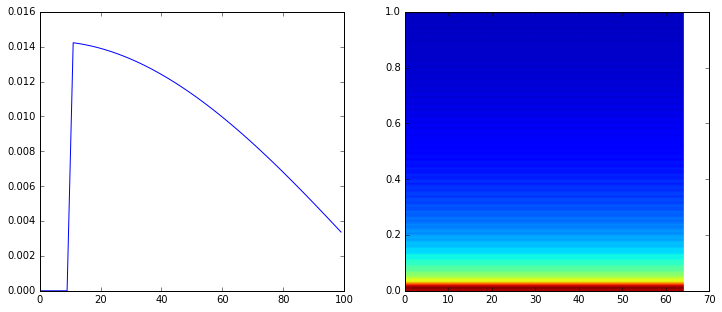

In [198]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(y)
# plt.show()
plt.subplot(122)
plt.specgram(y)
plt.show()

In [223]:
testX = sig.unit_impulse(100000, idx=10000)
Q = 70
y = np.zeros_like(testX)
for freq in peakFreqs:
    thisResonBas = getResonbp(freq,Q,1,sr)
    y = y + sig.lfilter(thisResonBas[0],thisResonBas[1],testX)

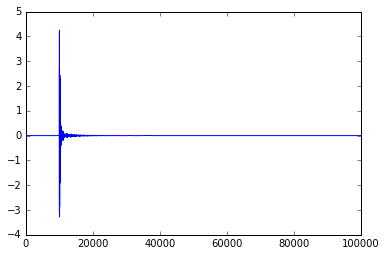

In [224]:
plt.plot(y)
plt.show()

/root/miniconda2/envs/findRefrain3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7017: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


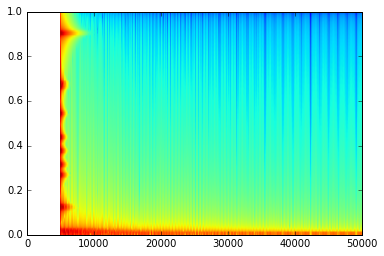

In [225]:
plt.specgram(y)
plt.show()

In [220]:
Audio(data=y,rate=sr)

## Simple Faust Modal model
```

import("stdfaust.lib");
bp(fc,Q) = fi.resonbp(fc,Q,1);




mymodel(Q) = _<:(
  //bp(50.47147412,Q), 
  //bp(99.31483617,Q),
  //bp(135.13330168,Q),
  //bp(224.67946544,Q),
  //bp(263.75415508,Q),
  //bp(299.57262058,Q),
  bp(341.90353436,Q),
  bp(2666.84756801,Q),
  bp( 5895.39379961,Q),
  bp(6921.10440269,Q),
  bp(8282.20609185,Q)
  
  
):>_;

imp = button("gate")<:_,_':-:max(0);
//process = imp;
process = imp:mymodel(70)*20:_;

```